# Preparación de los datos

In [2]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

Cultivos con los que trabaja la Red BAMX.

In [4]:
# Cultivos de interés
CULTIVOS = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']

# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(CULTIVOS)}")

Cantidad de cultivos de interés: 33


## Cargar datos

### SIAP

In [5]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


In [6]:
# Cambiar nombre de columna "Anio" a "Año"
df_siap = df_siap.rename(columns={"Anio":"Año"})

##### Aplicar filtros

In [7]:
# Filtrar años del 2020 en adelante
df_siap = df_siap[df_siap['Año'] >= 2020]

In [8]:
# Filtrar cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(CULTIVOS)]

##### Dimensiones de los datos

In [9]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (387646, 10)



##### Tipos de datos

In [10]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico

Convertimos estas variables object a flotantes

In [11]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']

# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



##### Valores faltantes

In [12]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                   0
Municipio                 0
Superficie Sembrada       0
Superficie Cosechada      0
Superficie Siniestrada    0
Produccion                0
Rendimiento               0
Año                       0
Mes                       0
Cultivo                   0
dtype: int64


Definición de constantes

In [13]:
# Orden cronológico de los meses
MESES_CRONOLOGICO = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Lista de colores para cada año
COLORES = ['#ffd343', '#42ff75', '#426eff', '#ff42cc']

# Lista de cultivos únicos
CULTIVOS_UNICOS = list(df_siap['Cultivo'].unique())

# Lista de años únicos
AÑOS_UNICOS = list(df_siap['Año'].unique())

# Lista de estado únicos
ESTADOS_UNICOS = list(df_siap['Entidad'].unique())

### SNIIM

In [14]:
# Path al archivo parquet
url_sniim = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SNIIM.parquet'
# Cargar archivo parquet como DataFrame
df_sniim = pd.read_parquet(url_sniim)
# Inspeccionar primeros elementos del DataFrame
df_sniim.sample(n=5)

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
296196,03/12/2018,Pieza,Distrito Federal,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",20.0,25.0,20.0,nan,coliflor grande_primera
570789,15/05/2018,Kilogramo,Colima,"Coahuila: Central de Abasto de La Laguna, Torreón",12.0,13.0,12.5,nan,melon cantaloupe # 36_primera
449335,15/03/2019,Pieza,Puebla,Chiapas: Central de Abasto de Tuxtla Gutiérrez,5.0,8.0,5.0,nan,lechuga romanita mediana_primera
537048,14/08/2023,Caja de 30 kg.,Chiapas,Durango: Centro de Distribución y Abasto de Gó...,28.0,30.0,29.0,nan,mango manililla_primera
773546,30/12/2020,Kilogramo,Baja California Sur,Baja California Sur: Unión de Comerciantes de ...,7.0,8.0,7.0,nan,sandía rayada_primera


Los valores de precio están estandarizados a KG y por ende las columnas "Presentacion" y "Observacion" son remanentes que podemos eliminar

In [15]:
# Descartamos columnas Presentacion y Observacion
df_sniim = df_sniim.drop(['Presentacion', 'Observacion'], axis=1)

##### Dimensiones de los datos

In [16]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (900763, 7)


##### Tipos de datos

In [17]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha                object
Origen               object
Destino              object
Precio Minimo       float64
Precio Maximo       float64
Precio Frecuente    float64
Cultivo              object
dtype: object



Notamos que la variable *Fecha* es de tipo **object**, por lo que la convertimos a **datetime** para facilitar futuros análisis

In [18]:
# Efectuar conversión especificando el formato específico de la fecha
df_sniim['Fecha'] = pd.to_datetime(df_sniim['Fecha'], format="%d/%m/%Y")
# Inspeccionar nuevamente el tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha               datetime64[ns]
Origen                      object
Destino                     object
Precio Minimo              float64
Precio Maximo              float64
Precio Frecuente           float64
Cultivo                     object
dtype: object



##### Aplicar filtros

In [19]:
#Filtramos nuestro DataFrame solo para los años 2020 - 2023 
df_sniim = df_sniim[df_sniim['Fecha'].dt.year >= 2020]

Nota: a causa de la diferencia en el nombre de los cultivos entre los DataFrames, el filtrado con los cultivos de interés de la Red BAMX se dejará para más adelante

##### Valores faltantes

In [20]:
# Valores faltantes
print(f"Valores faltantes:\n {df_sniim.isna().sum()}")

Valores faltantes:
 Fecha               0
Origen              0
Destino             0
Precio Minimo       0
Precio Maximo       0
Precio Frecuente    0
Cultivo             0
dtype: int64


## Juntar DataFrames

Antes de poder juntar los DataFrames es necesario realizar ciertos pasos para homologar los datos:

- Ajustar los nombres de los estados de Origen en los datos del SNIIM
- Ajustar los nombres de los cultivos del SNIIM
- Promediar los precios del SNIIM de manera mensual
- Calcular los valores del SIAP de manera mensual

Debido a su incompatibilidad, se descartarán las columnas de *Municipio* y *Destino*, del SIAP y SNIIM, respectivamente. No obstante, estas columnas en los DataFrames originales serán utilizadas en análisis posteriores.

In [21]:
# Eliminar columna 'Destino'
df_sniim_dest = df_sniim.drop('Destino', axis=1)

# Eliminar columna 'Municipio'
df_siap_mun = df_siap.drop('Municipio', axis=1)


# En ambos casos es necesario sumar los valores numericos que coincidad en Estado, Año, Mes y Cultivo 
df_sniim_dest = df_sniim_dest.groupby(['Fecha', 'Origen', 'Cultivo'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].sum().reset_index()
df_siap_mun = df_siap_mun.groupby(['Año', 'Mes', 'Entidad', 'Cultivo'])[['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Produccion', 'Rendimiento']].sum().reset_index()

##### Ajustar los nombres de los estados de Origen

In [22]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_sniim in df_sniim_dest['Origen'].unique():
    if estado_sniim not in df_siap_mun['Entidad'].unique():
        print(estado_sniim)

Estados del SNIIM no presentes en el SIAP:

Distrito Federal
Importación
Nacional


Reemplazamos "Distrito Federal" por "Ciudad de México" tal como viene en el SIAP. Descartamos las filas con datos "Importación" y "Nacional"

In [23]:
# Creamos una copia del DataFrame
df_sniim_dest_orig = df_sniim_dest.copy()

# Reemplazamos Distrito Federal por Ciudad de México
condicion = df_sniim_dest['Origen'] == "Distrito Federal"
df_sniim_dest_orig.loc[condicion, 'Origen'] = 'Ciudad de México' 

# Descartamos la filas cuyo valor en la columna "Origen" es Importación o Nacional
df_sniim_dest_orig = df_sniim_dest_orig[(df_sniim_dest_orig['Origen'] != 'Importación') | (df_sniim_dest_orig['Origen'] != 'Nacional')]

##### Ajustar los nombres de los cultivos del SNIIM

Para esto debemos tomar como referencia la lista de cultivos ofrecida por el experto de la red BAMX.

In [24]:
# Inspeccionamos nuevamente algunos elementos de la lista de cultivos
CULTIVOS[:10]

['Tomate rojo (jitomate)',
 'Chile verde',
 'Limón',
 'Pepino',
 'Plátano',
 'Mango',
 'Garbanzo',
 'Brócoli',
 'Cebolla',
 'Sandía']

Ahora inspeccionamos los cultivos de los datos del SNIIM.

In [25]:
# Inspeccionar algunos nombres de cultivos
df_sniim_dest_orig['Cultivo'].sample(n=10)

109197              cebolla morada_primera
140035         calabacita italiana_primera
240993    lechuga romanita mediana_primera
114267               chile mirasol_primera
69762                   col grande_primera
397549             chile puya seco_primera
211488               chile pasilla_primera
9742                  uva cardenal_primera
128128                    cilantro_primera
149170                      acelga_primera
Name: Cultivo, dtype: object

El formato consiste en el nombre de los cultivos seguido por una descripción de la variedad.
Debido a que en el SIAP no se maneja variedad, para poder homologar los datos nos quedamos solamente con el nombre de los cultivos. No obstante, esto aplica solo para los cultivos cuyo nombre consiste en una sola palabra. Para los nombres con más palabras utilizamos un abordaje manual. 

In [26]:
# Nombres de cultivo con más de una palabra
[cultivo for cultivo in CULTIVOS if len(cultivo.split(' ')) > 1]

['Tomate rojo (jitomate)', 'Chile verde', 'Tomate verde', 'Toronja (pomelo)']

In [27]:
# Creamos una copia del DataFrame
df_sniim_dest_orig_cult = df_sniim_dest_orig.copy()

# Creamos una nueva columna en nuestro DataFrame para almacenar los nuevos nombres de los cultivos
df_sniim_dest_orig_cult['Cultivo SIAP'] = df_sniim_dest_orig_cult['Cultivo']

# Tomate rojo (jitomate): reemplazamos los cultivos "tomate bola_primera" y "tomate saladette_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_dest_orig_cult['Cultivo SIAP'].isin(['tomate bola_primera', 'tomate saladette_primera'])

# Modificar los valores en esas filas
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate rojo (jitomate)'

# Tomate verde: reemplazamos el cultivo "tomate verde_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_dest_orig_cult['Cultivo SIAP'] == 'tomate verde_primera'

# Modificar los valores en esas filas
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate verde'

# Toronja (pomelo): reemplazamos el cultivo "toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera" y "toronja rosada_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_dest_orig_cult['Cultivo SIAP'].isin(["toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera", "toronja rosada_primera"])

# Modificar los valores en esas filas
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Toronja (pomelo)'

# Chile verde: reemplazamos el cultivo 'chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera', 'chile jalapeño_primera' y 'chile habanero_primera'

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_dest_orig_cult['Cultivo SIAP'].isin(['chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera',
                                       'chile jalapeño_primera', 'chile habanero_primera'])

# Modificar los valores en esas filas
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Chile verde'

# Nopalitos: en el SNIIM vienen solamente como Nopal

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_dest_orig_cult['Cultivo SIAP'].isin(['nopal grande_primera', 'nopal_primera'])

# Modificar los valores en esas filas
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Nopalitos'

Podemos automatizar el ajuste de los nombres de cultivo con una sola palabra utilizando expresiones regulares

In [28]:
# Condición para ignorar los cultivos que ya modificamos
condicion = ~df_sniim_dest_orig_cult['Cultivo SIAP'].isin(['Tomate rojo (jitomate)', 'Tomate verde', 'Toronja (pomelo)', 'Nopalitos', 'Chile verde'])

# Expresión regular para capturar la primera palabra
pattern = r'^([^\W_]+)'

# Aplicar la expresión regular para mantener solo la primera palabra
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_dest_orig_cult[condicion]['Cultivo SIAP'].str.extract(pattern).values

# Reemplazar la primera letra por mayúscula
df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_dest_orig_cult.loc[condicion, 'Cultivo SIAP'].str.title()

# Inspeccionar nuevamente algunos nombres de cultivos
df_sniim_dest_orig_cult['Cultivo SIAP'].sample(n=10)

222655       Chayote
147098    Yerbabuena
7007         Lechuga
339643         Chile
107374       Naranja
276539       Ciruela
310069     Cacahuate
370024         Chile
392329        Rábano
155928     Cacahuate
Name: Cultivo SIAP, dtype: object

Utilizamos nuevamente la lista de cultivos para filtrar el DataFrame

In [29]:
# Filtramos el DataFrame para quedarnos solo con los cultivos de interés
df_sniim_dest_orig_cult = df_sniim_dest_orig_cult[df_sniim_dest_orig_cult['Cultivo SIAP'].isin(CULTIVOS)]

# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim_dest_orig_cult.shape}")

# Inspeccionamos el DataFrame
df_sniim_dest_orig_cult.sample(n=5)

Dimensión de los datos: (252920, 7)


,Fecha,Origen,Cultivo,Precio Minimo,Precio Maximo,Precio Frecuente,Cultivo SIAP
216858,2021-12-20,Nayarit,berenjena_primera,93.0,97.0,95.0,Berenjena
51267,2020-05-25,Baja California Sur,calabacita italiana_primera,8.0,15.0,8.0,Calabacita
170194,2021-07-29,Baja California,fresa_primera,60.0,60.0,60.0,Fresa
384436,2023-05-10,Nayarit,melón cantaloupe # 12_primera,20.0,22.0,21.0,Melón
202243,2021-11-04,Importación,pera mantequilla_primera,40.0,42.5,42.5,Pera


Debido a la manipulación que realizamos con los cultivos del SNIIM para homologarlos con los del SIAP, es posible que un mismo cultivo presente distintos precios para una misma fecha. Para abordar esto, identificamos los casos en los que estos sucede y promediamos los precios asociados a una misma fecha.

##### Promedio mensual de precios SNIIM

In [30]:
# Desglosar la columna Fecha en dos columnas adicionales para el año y el mes
df_sniim_dest_orig_cult['Año'] = df_sniim_dest_orig_cult['Fecha'].dt.year
df_sniim_dest_orig_cult['Mes'] = df_sniim_dest_orig_cult['Fecha'].dt.month

# Agrupar por Año, Mes, Origen, Destino y Cultivo SIAP, y calcular el promedio de los precios
df_sniim_dest_orig_cult_mens = df_sniim_dest_orig_cult.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].mean().reset_index()

# Diccionario para mapear números de mes a nombres de mes
meses_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Aplicar el mapeo a la columna 'Mes'
df_sniim_dest_orig_cult_mens['Mes'] = df_sniim_dest_orig_cult_mens['Mes'].map(meses_dict)

# DataFrame resultante
df_sniim_dest_orig_cult_mens

,Año,Mes,Origen,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Enero,Aguascalientes,Brócoli,11.181818,13.181818,12.181818
1,2020,Enero,Aguascalientes,Calabacita,17.657846,18.956615,18.454923
2,2020,Enero,Aguascalientes,Coliflor,12.045455,14.045455,13.045455
3,2020,Enero,Aguascalientes,Guayaba,8.750000,9.584091,9.165909
4,2020,Enero,Aguascalientes,Lechuga,5.363636,7.363636,6.363636
...,...,...,...,...,...,...,...
8905,2023,Octubre,Zacatecas,Cebolla,30.000000,38.000000,38.000000
8906,2023,Octubre,Zacatecas,Chile verde,26.988235,31.576471,29.564706
8907,2023,Octubre,Zacatecas,Lechuga,12.882353,12.882353,12.882353
8908,2023,Octubre,Zacatecas,Tomate verde,9.777778,12.666667,11.500000


##### Obtención de producción mensual

Por defecto, el SIAP arroja los datos numéricos (Superficie Sembrada, Superficie Cosechada, Superficie Siniestrada, Produccion, Rendimiento) de manera acumulativa. Esto implica que los valores de, por ejemplo Febrero, son los valores de Enero más los de Febrero; los valores de Marzo son los valores de Enero, más los de Febrero, más los de Marzo; y así sucesivamente. Nosotros esatmos interesados en analizar los valores de manera mensual y por ende, es necesario que a los valores de cada mes le restemos los valores de los meses previos.

In [31]:
# Ordenamos el DataFrame con base en el orden cronológico de los meses
df_siap_mun['Mes'] = pd.Categorical(df_siap_mun['Mes'], categories=MESES_CRONOLOGICO, ordered=True)  # Convertir 'Mes' en una categoría con el orden cronológico
df_siap_mun = df_siap_mun.sort_values(by='Mes')  # Ordenar DataFrame con base en la columna 'Mes'

# Crear DataFrame en el que almacenaremos la producción mensual no acumulativa
df_siap_diff = pd.DataFrame(columns=df_siap_mun.columns)

# Iteramos por año
for año in AÑOS_UNICOS[::-1]:

    # Iteramos por estado
    for estado in ESTADOS_UNICOS:
        
        # Iteramos por cultivo
        for cultivo in CULTIVOS_UNICOS:

            # Datos del estado, año y cultivo en turno
            df_ent_year_cult = df_siap_mun[(df_siap_mun['Entidad'] == estado) & (df_siap_mun['Año'] == año) & (df_siap_mun['Cultivo'] == cultivo)]

            # Resta de valores de meses previos
            df_ent_year_cult['Superficie Sembrada'] = df_ent_year_cult['Superficie Sembrada'].diff().fillna(df_ent_year_cult['Superficie Sembrada'])
            df_ent_year_cult['Superficie Cosechada'] = df_ent_year_cult['Superficie Cosechada'].diff().fillna(df_ent_year_cult['Superficie Cosechada'])
            df_ent_year_cult['Superficie Siniestrada'] = df_ent_year_cult['Superficie Siniestrada'].diff().fillna(df_ent_year_cult['Superficie Siniestrada'])
            df_ent_year_cult['Produccion'] = df_ent_year_cult['Produccion'].diff().fillna(df_ent_year_cult['Produccion'])
            #df_ent_year_cult['Rendimiento'] = df_ent_year_cult['Rendimiento'].diff().fillna(df_ent_year_cult['Rendimiento'])

            # Alamacenar resultados en el nuevo DataFrame
            df_siap_diff = pd.concat([df_siap_diff, df_ent_year_cult], axis=0)

            df_siap_diff = df_siap_diff.reset_index(drop=True)

# Inspeccionamos el nuevo DataFrame
df_siap_diff

,Año,Mes,Entidad,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento
0,2020,Enero,Baja California Sur,Berenjena,11.0,0.00,0.0,0.00,0.00
1,2020,Febrero,Baja California Sur,Berenjena,0.0,1.50,0.0,27.30,18.20
2,2020,Marzo,Baja California Sur,Berenjena,8.5,1.00,0.0,19.00,18.52
3,2020,Abril,Baja California Sur,Berenjena,0.8,0.25,0.0,4.70,18.55
4,2020,Mayo,Baja California Sur,Berenjena,1.0,0.25,0.0,4.75,18.58
...,...,...,...,...,...,...,...,...,...
29271,2023,Mayo,Nuevo León,Uva,0.0,0.00,0.0,0.00,0.00
29272,2023,Junio,Nuevo León,Uva,0.0,0.00,0.0,0.00,0.00
29273,2023,Julio,Nuevo León,Uva,0.0,4.10,0.0,12.95,6.33
29274,2023,Agosto,Nuevo León,Uva,0.0,0.00,0.0,0.00,6.33


##### Juntamos los DataFrames

In [32]:
# Realizar el merge
df_merge = pd.merge(
    df_siap_diff,
    df_sniim_dest_orig_cult_mens,
    how='inner',
    left_on=['Año', 'Mes', 'Entidad', 'Cultivo'],
    right_on=['Año', 'Mes', 'Origen', 'Cultivo SIAP']
)

# Eliminar las columnas duplicadas (puedes ajustar según tus necesidades)
df_merge = df_merge.drop(['Origen', 'Cultivo SIAP'], axis=1)

# Mostrar el DataFrame resultante
df_merge

,Año,Mes,Entidad,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Enero,Baja California Sur,Chile verde,1203.50,44.00,0.0,1000.00,45.96,18.000000,22.000000,18.000000
1,2020,Febrero,Baja California Sur,Chile verde,48.00,409.20,0.0,19294.69,120.63,17.684211,22.000000,17.684211
2,2020,Marzo,Baja California Sur,Chile verde,55.25,238.70,0.0,9918.11,123.70,15.000000,22.450000,18.750000
3,2020,Abril,Baja California Sur,Chile verde,59.40,370.00,0.0,19676.22,194.05,15.000000,25.000000,19.500000
4,2020,Mayo,Baja California Sur,Chile verde,54.15,89.55,0.0,4448.45,203.06,15.000000,25.000000,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7047,2023,Mayo,Nuevo León,Uva,0.00,0.00,0.0,0.00,0.00,111.142857,124.000000,114.285714
7048,2023,Junio,Nuevo León,Uva,0.00,0.00,0.0,0.00,0.00,110.363636,128.090909,115.454545
7049,2023,Julio,Nuevo León,Uva,0.00,4.10,0.0,12.95,6.33,86.428571,110.095238,99.238095
7050,2023,Agosto,Nuevo León,Uva,0.00,0.00,0.0,0.00,6.33,70.173913,90.434783,81.434783


##### Definimos constantes

In [33]:
# Lista de variables numéricas en el DataFrame
VARIABLES_NUMERICAS = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion", "Rendimiento",
                       "Precio Minimo", "Precio Maximo", "Precio Frecuente"]

## Detección de outliers

Primero inspeccionamos las variables numéricas de nuestros datos para una identificación burda de posibles outliers.

In [34]:
# Descripción de variables numéricas
df_merge.drop(columns='Año', axis=1).describe()

,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Precio Minimo,Precio Maximo,Precio Frecuente
count,7052.000000,7052.000000,7052.000000,7052.000000,7052.000000,7052.000000,7052.000000,7052.000000
mean,658.422808,601.746747,0.715231,11446.082221,185.212796,28.171976,32.588552,30.771912
std,5679.829604,3142.816796,22.206281,34062.908017,247.341494,31.799290,34.769725,33.724971
min,-292.200000,0.000000,0.000000,-0.010000,0.000000,0.550000,0.650000,0.580000
25%,0.000000,0.000000,0.000000,0.000000,15.480000,13.000000,15.000000,14.235446
50%,0.000000,1.500000,0.000000,620.000000,86.000000,18.859303,22.954545,21.110794
75%,7.625000,150.697500,0.000000,8535.007500,253.630000,30.280000,36.818182,33.967995
max,170717.070000,90396.930000,1500.000000,718771.580000,2582.000000,370.000000,391.000000,380.000000


Notamos que los valores mínimos de Superficie Sembrada y de Producción son negativos, lo cual no tiene sentido. Contamos la cantidad de valores negativos en estas dos variables, con el objetivo de identificar si cometimos un error en el cálculo de los valores mensuales, o si simplemente se trata de que hubo errores a la hora de registrar los datos. 

In [35]:
print(f"Cantidad de valores negativos en Superficie Sembrada: {sum(df_merge['Superficie Sembrada'] < 0)}\n")
print(f"Cantidad de valores negativos en Produccion: {sum(df_merge['Produccion'] < 0)}")

Cantidad de valores negativos en Superficie Sembrada: 2

Cantidad de valores negativos en Produccion: 1


Debido a la pequeña cantidad de valores faltantes, lo más factible es que se hayan cometido errores a la hora de registrar los datos. Por lo tanto, podemos simplemente eliminar estos valores negativos y continuar con el análisis.

In [36]:
# Descartamos filas con valores valores negativos
df_merge  = df_merge[(df_merge['Superficie Sembrada'] >= 0) & (df_merge['Produccion'] >= 0)]

# Descripción de variables numéricas
df_merge.drop(columns='Año', axis=1).describe()

,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Precio Minimo,Precio Maximo,Precio Frecuente
count,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000
mean,658.744484,601.808115,0.715536,11441.784867,185.156147,28.166463,32.583318,30.766632
std,5681.016172,3143.455842,22.211001,34063.720519,247.315156,31.803284,34.774044,33.729270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.550000,0.650000,0.580000
25%,0.000000,0.000000,0.000000,0.000000,15.480000,13.000000,15.000000,14.227500
50%,0.000000,1.500000,0.000000,620.000000,86.000000,18.851429,22.952632,21.100000
75%,8.000000,150.680000,0.000000,8529.010000,253.470000,30.280000,36.818182,33.965263
max,170717.070000,90396.930000,1500.000000,718771.580000,2582.000000,370.000000,391.000000,380.000000


In [37]:
# # Configuración de estilo de seaborn
# sns.set(style="white")

# # Lista de variables numéricas en el DataFrame
# variables_numericas = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", 
#                        "Produccion", "Rendimiento", "Precio Minimo", "Precio Maximo", "Precio Frecuente"]

# # Crear una sola figura para todos los boxplots
# plt.figure(figsize=(15, 10))

# # Crear boxplots para cada variable en la misma figura
# for i, variable in enumerate(variables_numericas, 1):
#     plt.subplot(2, 4, i)
#     sns.boxplot(y=df_merge[variable])
    
#     # Añadir etiquetas al eje y
#     if "Superficie Sembrada" == variable:
#         plt.ylabel("Hectáreas")
#     elif variable == "Produccion":
#         plt.ylabel("Toneladas")
#     elif variable == "Rendimiento":
#         plt.ylabel("Tonelada/Hectárea")
#     elif variable == "Precio Minimo":
#         plt.ylabel("Pesos")
#     else:
#         plt.ylabel("")
    
#     plt.title(f'{variable}')

# # Ajustar el diseño de los subplots
# plt.tight_layout()

# # Mostrar la figura
# plt.show()

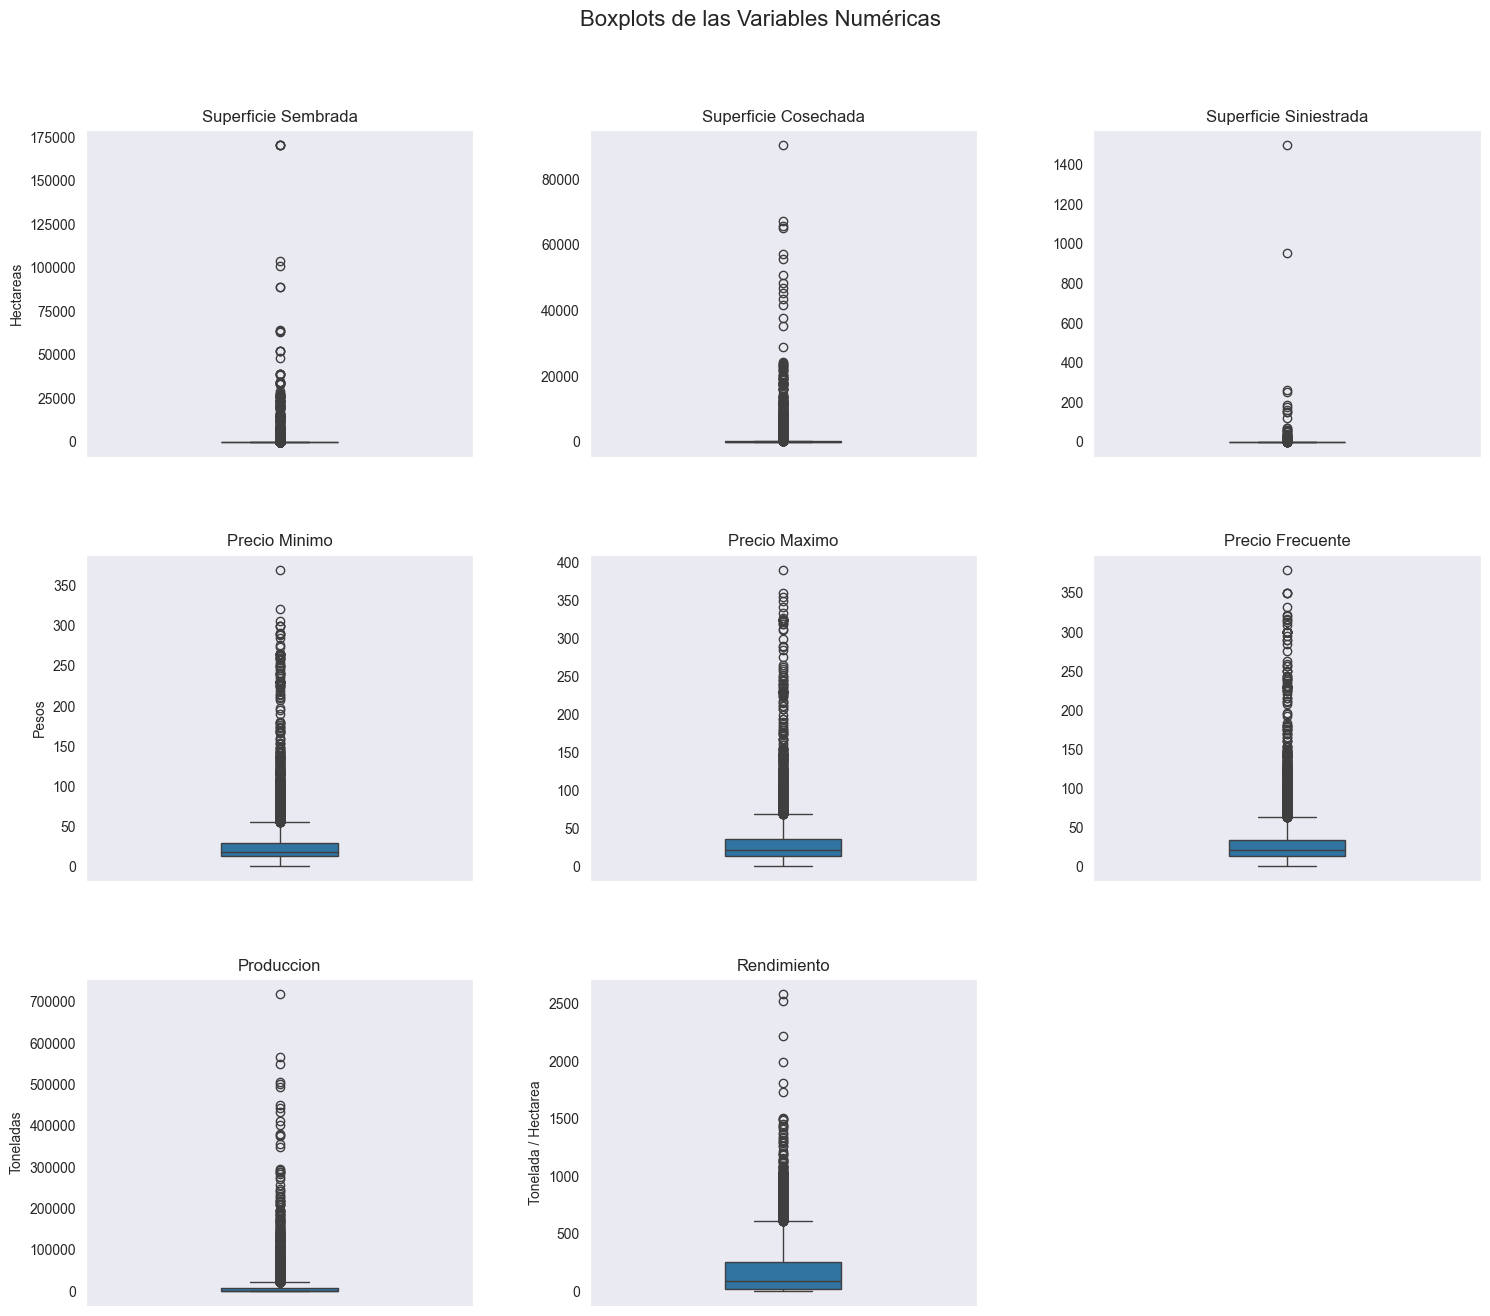

In [38]:
# Fijamos estilo
sns.set_style("dark")

# Lista con re-ordenamiento de las variables numéricas
variables_numericas = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", 
                       "Precio Minimo", "Precio Maximo", "Precio Frecuente", "Produccion", "Rendimiento"]

# Configurar la figura y los subplots
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(variables_numericas):
    sns.boxplot(data=df_merge, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de las Variables Numéricas', fontsize=16)

axes[0].set_ylabel('Hectareas')
axes[3].set_ylabel('Pesos')
axes[6].set_ylabel('Toneladas')
axes[7].set_ylabel('Tonelada / Hectarea')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

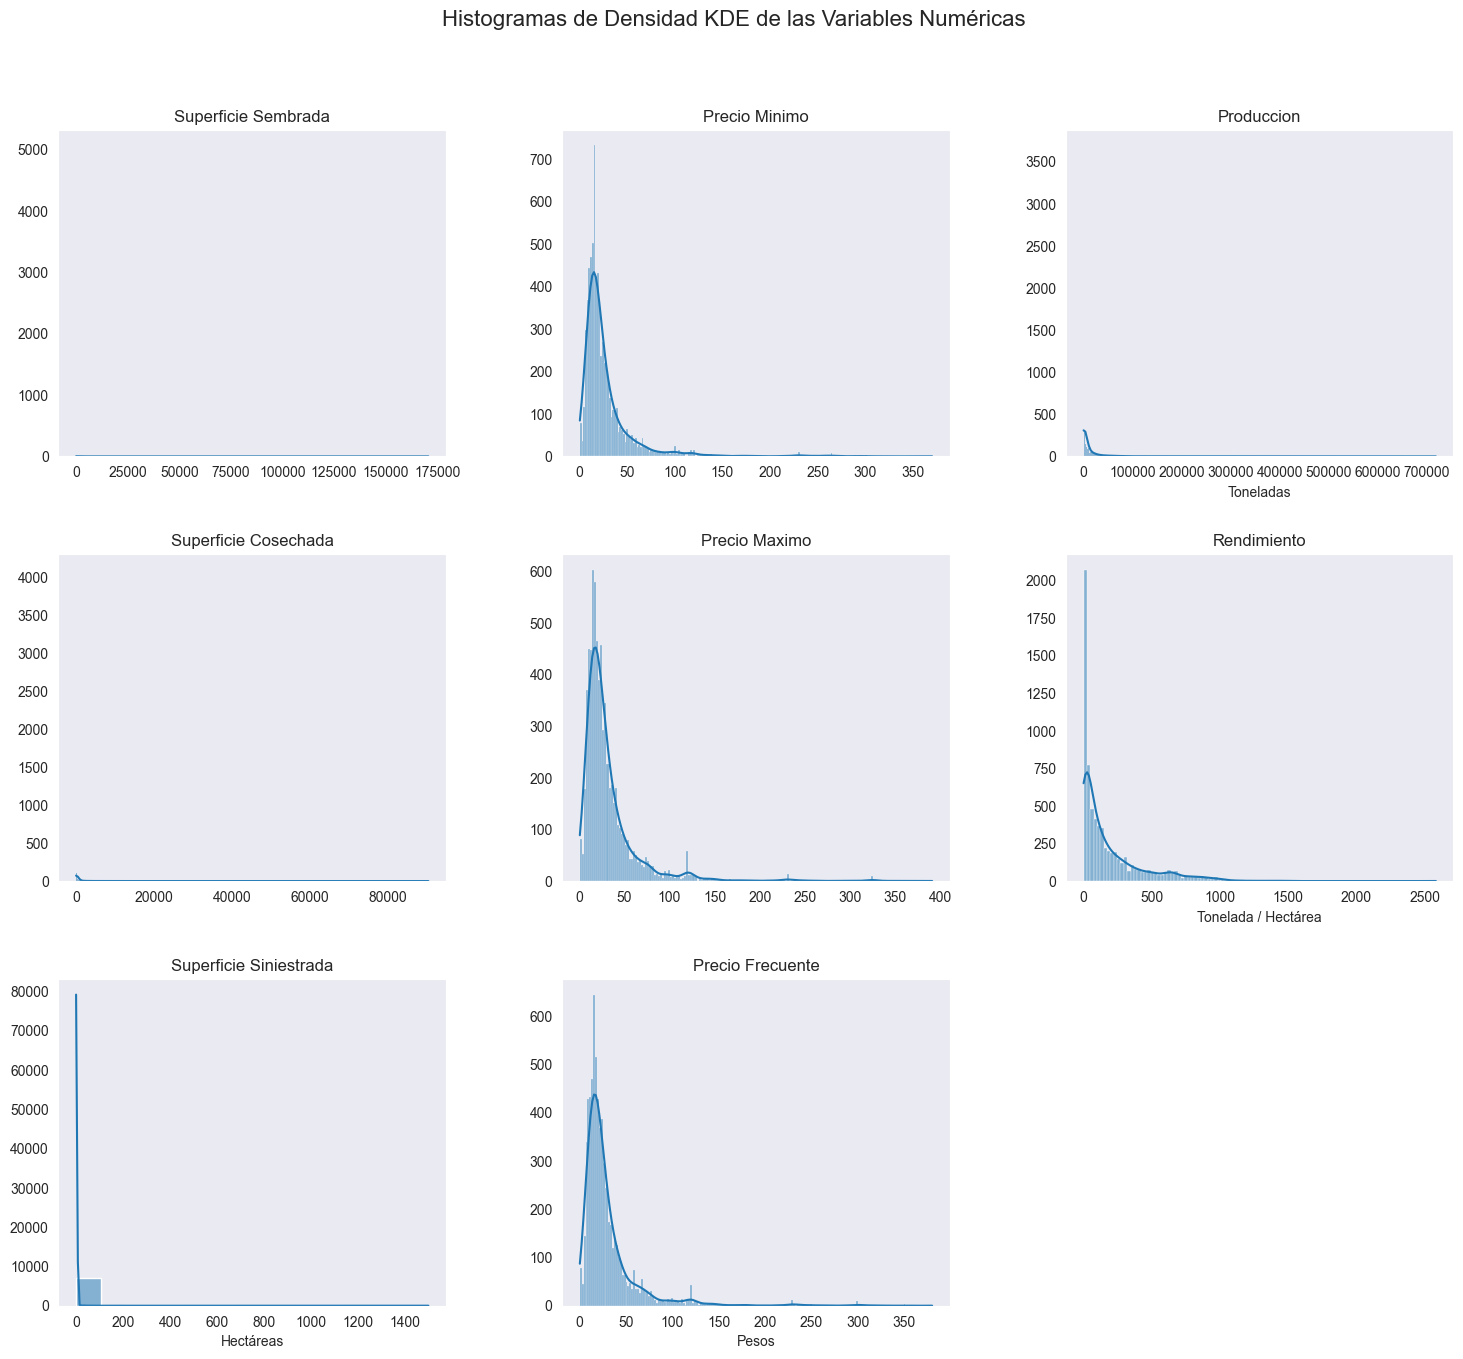

In [38]:
# Lista con re-ordenamiento de las variables numéricas
variables_numericas = ["Superficie Sembrada", 
                       "Precio Minimo", "Produccion", "Superficie Cosechada", "Precio Maximo", "Rendimiento", "Superficie Siniestrada", "Precio Frecuente"]

# Configurar la figura y los subplots
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear histogramas de densidad kde
for i, variable in enumerate(variables_numericas):
    sns.histplot(data=df_merge, x=variable, kde=True, ax=axes[i])
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía correspondiente a la variable FastingBS
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Histogramas de Densidad KDE de las Variables Numéricas', fontsize=16)

axes[2].set_xlabel('Toneladas')
axes[5].set_xlabel('Tonelada / Hectárea')
axes[6].set_xlabel('Hectáreas')
axes[7].set_xlabel('Pesos')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()


##### Método Local Factor Outlier

In [39]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_merge.drop(columns=['Año', 'Entidad', 'Mes', 'Cultivo'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_merge) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 787
Porcentaje con respecto al total de datos: 11.16%


Inspeccionamos algunos datos outlier según Local Factor Outlier

In [40]:
# Obtener datos outlier según LOF
outliers_LOF = df_merge[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=20)

,Año,Mes,Entidad,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Precio Minimo,Precio Maximo,Precio Frecuente
1566,2020,Marzo,Chiapas,Limón,0.00,605.00,0.00,1071.68,14.42,9.868750,11.580000,9.868750
4745,2022,Julio,México,Tomate verde,487.16,215.55,0.00,2956.73,220.15,15.666667,17.666667,16.666667
2180,2021,Mayo,Aguascalientes,Lechuga,194.00,0.00,0.00,0.00,84.33,6.000000,8.000000,7.000000
2943,2021,Febrero,Michoacán,Mango,0.00,874.25,0.00,4347.70,51.33,20.000000,26.052632,25.052632
6245,2023,Enero,Jalisco,Fresa,6.00,0.00,0.00,0.00,0.00,53.333333,104.444444,104.444444
398,2020,Julio,Baja California,Chile verde,0.00,0.00,0.00,0.00,32.35,77.500000,77.500000,77.500000
870,2020,Septiembre,Jalisco,Melón,0.00,0.00,0.00,0.00,346.97,16.800000,20.800000,20.800000
5242,2022,Junio,Veracruz,Mango,0.00,5185.20,0.00,29023.53,385.03,20.000000,25.000000,24.590909
6781,2023,Febrero,Oaxaca,Mango,0.00,8151.30,0.00,35408.56,37.39,38.724211,42.161053,40.930877
2461,2021,Enero,Ciudad de México,Lechuga,77.00,19.00,0.00,254.50,13.39,12.200000,15.050000,15.000000


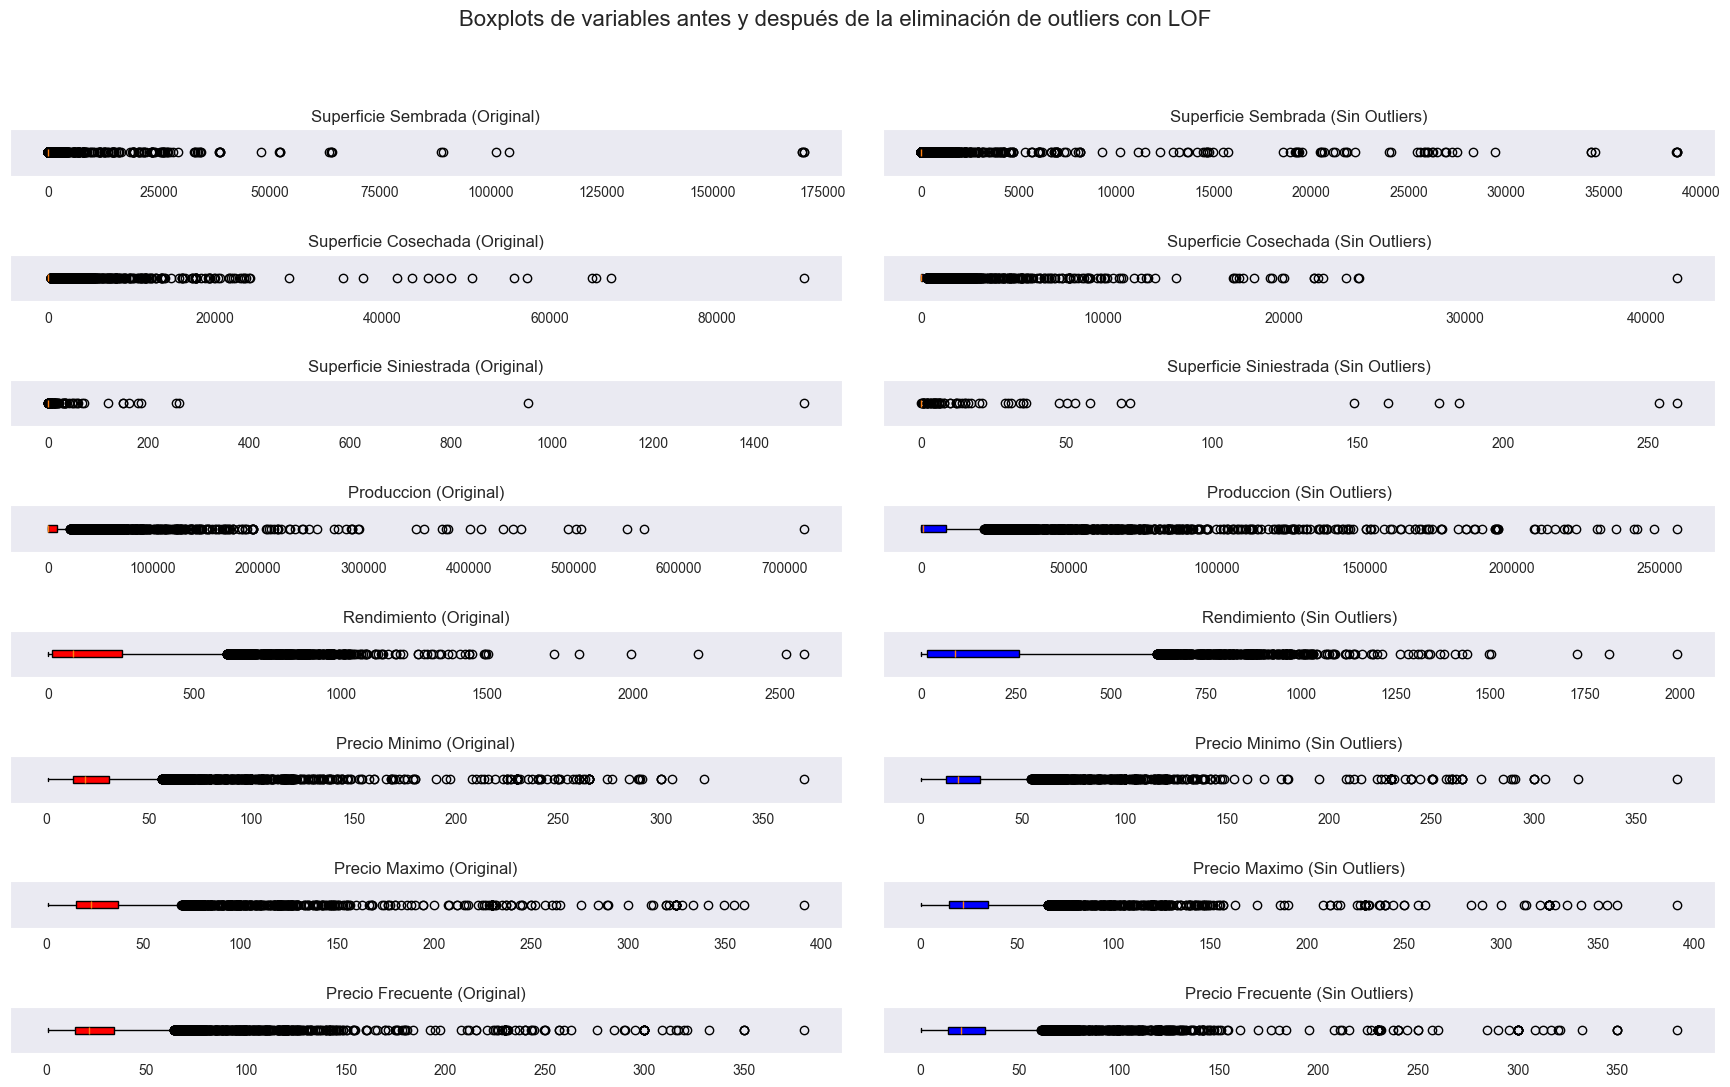

In [41]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_merge[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_merge[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

##### Método Isolation Forest

In [42]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas
X = df_merge.drop(columns=['Año', 'Entidad', 'Mes', 'Cultivo'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_merge) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")


Cantidad de outliers: 495
Porcentaje con respecto al total de datos: 7.02%


Inspeccionamos algunos datos outlier según Isolation Forest

In [43]:
# Obtener datos outlier según IF
outliers_IF = df_merge[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=20)

,Año,Mes,Entidad,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Precio Minimo,Precio Maximo,Precio Frecuente
5390,2022,Enero,Chihuahua,Nuez,101269.04,0.00,0.0,0.00,0.00,289.523810,289.523810,289.523810
3798,2022,Septiembre,Nayarit,Chile verde,4.60,36.00,0.0,244.20,178.00,115.476190,117.476190,116.476190
6955,2023,Mayo,Chihuahua,Nuez,0.00,0.00,0.0,0.00,0.00,265.000000,325.000000,300.000000
5062,2022,Marzo,Colima,Limón,0.00,1523.58,0.0,23573.25,27.55,97.680227,130.049773,126.310682
5277,2022,Julio,Veracruz,Piña,0.00,1593.00,0.0,80873.42,524.67,64.619048,73.571429,70.476190
1074,2020,Abril,Michoacán,Mango,0.00,11156.55,0.0,34509.48,180.32,37.155385,42.884615,42.904615
6957,2023,Julio,Chihuahua,Nuez,0.00,0.00,0.0,0.00,0.00,260.000000,325.000000,300.000000
1974,2021,Enero,Sinaloa,Chile verde,14977.76,7758.45,0.0,167125.34,270.69,79.750000,88.850000,87.675000
6426,2023,Septiembre,Michoacán,Durazno,0.00,0.00,0.0,2554.06,282.16,254.005238,265.144286,257.299524
5228,2022,Abril,Veracruz,Limón,0.00,2557.95,0.0,45203.67,501.83,126.138421,147.180000,130.454211


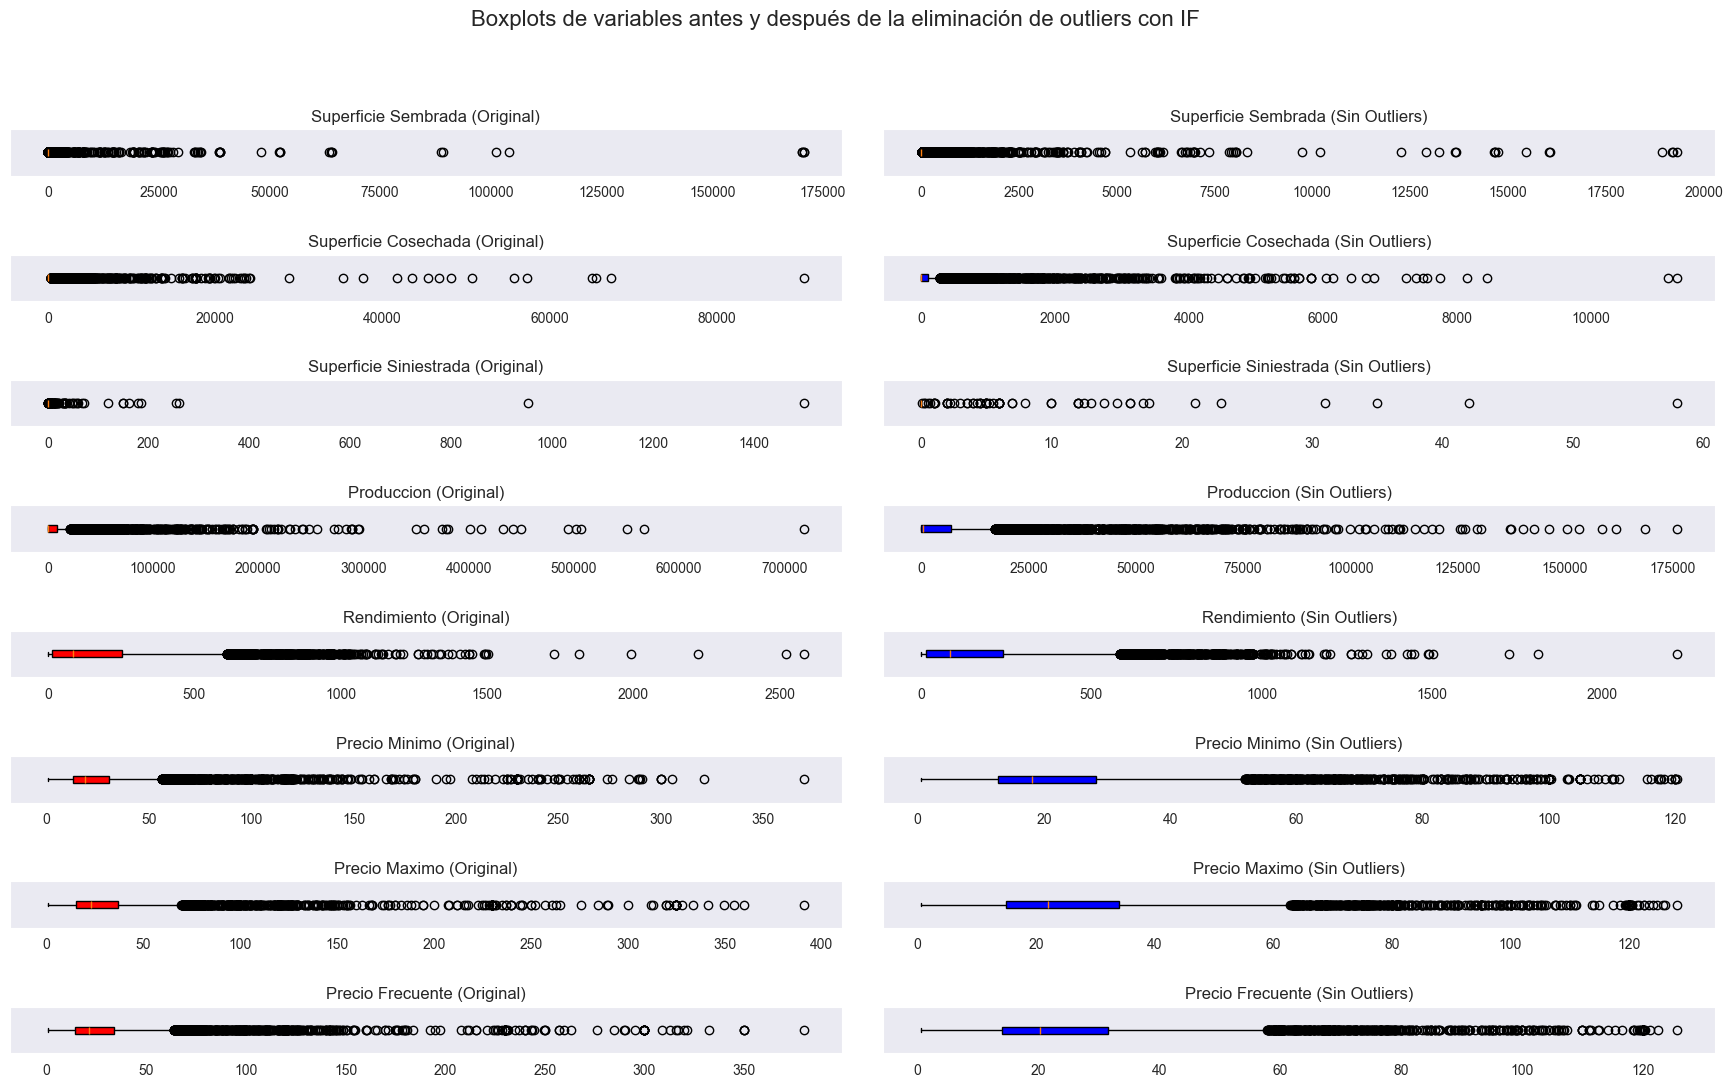

In [44]:
# Eliminar outliers del DataFrame
df_clean_IF = df_merge[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_merge[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los outliers putativos no nos permite identificarlos como verdaderamente valores atípicos.Es normal que ciertos cultivos, como la nuez, se mantengan con precios muy por encima de otros cultivos. Además, es esperable que en ciertas épocas, la producción de ciertos cultivos incremente de manera significativa. Por esto y otros factores, decidimos conservar los outliers putativos y continuar el EDA con el DataFrame completo.  

## Relaciones entre variables por visualización

In [45]:
# Magic command para hacer gráficas interactivas
#%matplotlib widget

### Análisis temporal: ¿En qué épocas del año es más probable que se generen excedentes? 

Analizamos la evolución de las variables númericas a lo largo de los años, para cada uno de los cultivos de interés. Para esto, vamos a ignorar la información geográfica, promediando los valores a lo largo de todos los estados.

In [46]:
# Promediamos por año, mes y cultivo
df_año_mes_cult = df_merge.groupby(['Año', 'Mes', 'Cultivo'])[VARIABLES_NUMERICAS].mean().reset_index()

# Ordenamos el DataFrame con base en el orden cronológico de los meses
df_año_mes_cult['Mes'] = pd.Categorical(df_año_mes_cult['Mes'], categories=MESES_CRONOLOGICO, ordered=True)  # Convertir 'Mes' en una categoría con el orden cronológico
df_año_mes_cult = df_año_mes_cult.sort_values(by='Mes')  # Ordenar DataFrame con base en la columna 'Mes'

In [47]:
# Función para obtener la etiqueta del eje y según el tipo de variable
def get_label(variable):
    if variable in ['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada']:
        return 'Hectáreas'
    elif variable in ['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']:
        return 'Pesos'
    elif variable == 'Produccion':
        return 'Toneladas'
    elif variable == 'Rendimiento':
        return 'Tonelada/Hectárea'
    else:
        return ''

In [48]:
# Fijamos estilo
sns.set_style("white")

# Función para actualizar el gráfico según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Graficar la producción promedio de todos los cultivos
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_año_mes_cult, palette=COLORES, ci=False, estimator='mean')
        title = f'{variable} Promedio de Todos los Cultivos por Mes y Año'
    else:
        # Graficar la producción del cultivo seleccionado
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_año_mes_cult[df_año_mes_cult['Cultivo'] == cultivo], palette=COLORES, ci=False)
        title = f'{variable} de {cultivo} por Mes y Año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')

    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Añadir la opción "Todos los cultivos" a la lista de cultivos
cultivos_con_todos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_con_todos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Para facilitar el análisis comparativo entre los distintos años, repetimos la gráfica pero ahora de manera acumulada. Esto no solo facilita comparar los patrones de evolución a lo largo de cada año, sino que permite comparar los valores totales de cada año simplemente inspeccionando el mes de Diciembre. 

In [49]:
# Función para actualizar el gráfico acumulado según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Graficar la producción acumulada promedio de todos los cultivos
        df_plot = df_año_mes_cult.groupby(['Año', 'Mes'])[variable].mean().groupby('Año').cumsum().reset_index()
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_plot, palette=COLORES, ci=False)
        title = f'{variable} Acumulado Promedio de Todos los Cultivos por Mes y Año'
    else:
        # Graficar la producción acumulada del cultivo seleccionado
        df_plot = df_año_mes_cult[df_año_mes_cult['Cultivo'] == cultivo].groupby(['Año', 'Mes'])[variable].mean().groupby('Año').cumsum().reset_index()
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_plot, palette=COLORES, ci=False)
        title = f'{variable} Acumulado de {cultivo} por Mes y Año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')
    
    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Añadir la opción "Todos los cultivos" a la lista de cultivos
cultivos_con_todos = ['Todos los cultivos'] + list(df_año_mes_cult['Cultivo'].unique())

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_con_todos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Zarzamora', 'Papa', 'Pap…

<function __main__.update_plot(cultivo, variable)>

Habiendo analizado el patrón de evolución a lo largo de los meses de los distintos años, procedemos a identificar cuáles son, en promedio, los meses con mejores métricas.

In [50]:
# Promediar los valores entre todos los años
df_promedio_anual = df_año_mes_cult.groupby('Mes')[VARIABLES_NUMERICAS].mean().reset_index()

# Función para actualizar el gráfico de barras horizontales según la variable y el cultivo seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Graficar barras horizontales para el promedio de todos los cultivos
        order = df_promedio_anual.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=df_promedio_anual, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para todos los cultivos por mes'
    else:
        # Filtrar datos por cultivo
        df_cultivo = df_año_mes_cult[df_año_mes_cult['Cultivo'] == cultivo]

        # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
        order = df_cultivo.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=df_cultivo, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para {cultivo} por Mes'

    # Añadir título y etiquetas a los ejes
    plt.title(title, pad=20)
    plt.xlabel(f'{variable} Promedio Anual')
    plt.ylabel('Mes')

    # Añadir label x dinámico
    plt.xlabel(get_label(variable))

    # Eliminar bordes
    plt.gca().spines['left'].set_visible(False)  # Izquierdo
    plt.gca().spines['top'].set_visible(False)   # Superior
    plt.gca().spines['right'].set_visible(False) # Derecho
    plt.gca().spines['bottom'].set_visible(False) # Inferior

    # Eliminar xticks
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Añadir la opción "Todos los cultivos" a la lista de cultivos
cultivos_con_todos = ['Todos los cultivos'] + df_año_mes_cult['Cultivo'].unique().tolist()

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_con_todos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)

interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Zarzamora', 'Papa', 'Pap…

<function __main__.update_plot(cultivo, variable)>

Procedemos a analizar la evolución de las distintas variables numéricas pero ahora a lo largo de todo el periodo del que se tienen datos. Prestamos especial interés a los meses identificados con mejores y peores métricas.

In [51]:
# Creamos una copia de nuestro DataFrame
df_merge_fechas = df_merge.copy()

# Asegúrate de tener las columnas Año y Mes en formato string
df_merge_fechas['Año'] = df_merge_fechas['Año'].astype(str)
df_merge_fechas['Mes'] = df_merge_fechas['Mes'].astype(str)

# Mapea los nombres de los meses a números
meses_dict = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df_merge_fechas['Mes'] = df_merge_fechas['Mes'].map(meses_dict)

# Combina las columnas Año y Mes en una nueva columna 'Fecha'
df_merge_fechas['Fecha'] = pd.to_datetime(df_merge_fechas['Año'] + '-' + df_merge_fechas['Mes'].astype(str), format='%Y-%m')

# Agrupa por mes y año y calcula el promedio de las columnas numéricas
df_grouped = df_merge_fechas.groupby(['Fecha', 'Cultivo'])[VARIABLES_NUMERICAS].mean().reset_index()

# Filtra los datos para el rango de fechas que deseas
start_date = '2019-12-25'
end_date = '2023-09-10'
df_filtered = df_grouped[(df_grouped['Fecha'] >= start_date) & (df_grouped['Fecha'] <= end_date)]

In [52]:
# Función para graficar
def plot_graph(cultivo, variable):
    plt.subplots(1, 1, figsize=(12, 8))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable para todos los cultivos
        df_all_cultivos_var1 = df_filtered.groupby('Fecha')[variable].mean().reset_index()
        plt.plot(df_all_cultivos_var1['Fecha'], df_all_cultivos_var1[variable], marker='o', linestyle='-', color='b', label=variable)

        # Añadir título
        plt.title(f'{variable} de todos los cultivos', pad=30, fontsize=16, fontweight='bold', va='center')

    else:
        # Filtra por el cultivo seleccionado
        df_cultivo = df_filtered[df_filtered['Cultivo'] == cultivo]
        
        # Grafica el promedio de la variable1 para el cultivo seleccionado
        plt.plot(df_cultivo['Fecha'], df_cultivo[variable], marker='o', linestyle='-', color='b', label=variable)
        
        # Añadir título
        plt.title(f'{variable} de {cultivo}', pad=30)

    # Etiquetas para el eje y
    plt.ylabel(get_label(variable), labelpad=20)

    plt.xlabel('Fecha', labelpad=20)
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        
    plt.show()

# Añadir opción "Todos los cultivos" al widget de cultivos
cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable=widgets.Dropdown(options=variables_numericas, value='Superficie Sembrada', description='Variable'))

interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable)>

Podemos inspeccionar simultaneamente la evolución de las distintas parejas de variables numéricas en busca de alguna relación significativa.

In [53]:
# Función para graficar
def plot_graph(cultivo, variable1, variable2):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable1 para todos los cultivos
        df_all_cultivos_var1 = df_filtered.groupby('Fecha')[variable1].mean().reset_index()
        axs[0].plot(df_all_cultivos_var1['Fecha'], df_all_cultivos_var1[variable1], marker='o', linestyle='-', color='b', label=variable1)
        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Grafica el promedio de la variable2 para todos los cultivos
        df_all_cultivos_var2 = df_filtered.groupby('Fecha')[variable2].mean().reset_index()
        axs[1].plot(df_all_cultivos_var2['Fecha'], df_all_cultivos_var2[variable2], marker='o', linestyle='-', color='r', label=variable2)
        axs[1].legend(loc='upper right')
        
        # Calcular la correlación
        corr_value = df_all_cultivos_var1[variable1].corr(df_all_cultivos_var2[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.505, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=18, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    else:
        # Filtra por el cultivo seleccionado
        df_cultivo = df_filtered[df_filtered['Cultivo'] == cultivo]
        
        # Grafica el promedio de la variable1 para el cultivo seleccionado
        axs[0].plot(df_cultivo['Fecha'], df_cultivo[variable1], marker='o', linestyle='-', color='b', label=variable1)
        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Grafica el promedio de la variable2 para el cultivo seleccionado
        axs[1].plot(df_cultivo['Fecha'], df_cultivo[variable2], marker='o', linestyle='-', color='r', label=variable2)
        axs[1].legend(loc='upper right')

        # Calcular la correlación
        corr_value = df_cultivo[variable1].corr(df_cultivo[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.515, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=14, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    # Etiquetas para el eje y
    axs[0].set_ylabel(get_label(variable1))
    axs[1].set_ylabel(get_label(variable2))

    plt.xlabel('Fecha')
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        
    plt.show()

# ... (código para obtener opciones de widgets)

# Añadir opción "Todos los cultivos" al widget de cultivos
cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable1=widgets.Dropdown(options=variables_numericas, value='Superficie Sembrada', description='Variable 1'),
         variable2=widgets.Dropdown(options=variables_numericas, value='Superficie Cosechada', description='Variable 2'))

interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable1, variable2)>

### Análisis geográfico: ¿En qué ubicaciones es más probable que se generen excedentes? 

In [54]:
import geopandas
geo_df = geopandas.read_file("https://gist.githubusercontent.com/walkerke/76cb8cc5f949432f9555/raw/363c297ce82a4dcb9bdf003d82aa4f64bc695cf1/mx.geojson")
geo_df.head()

,id,name,state,mus09,pri10,sec10,ter10,gdp08,other10,geometry
0,1,Aguascalientes,Aguascalientes,17.1,6.34,28.74,64.28,84.70,0.64,"MULTIPOLYGON (((-102.21140 22.35450, -102.1908..."
1,2,Baja California,Baja California,15.4,5.44,31.64,61.68,83.07,1.24,"MULTIPOLYGON (((-114.09429 28.02418, -114.0774..."
2,3,Baja California Sur,Baja California Sur,3.0,9.18,17.48,72.37,94.64,0.97,"MULTIPOLYGON (((-109.79843 24.15516, -109.8028..."
3,4,Campeche,Campeche,7.0,19.24,21.20,57.11,395.55,2.45,"MULTIPOLYGON (((-91.52440 18.76659, -91.52457 ..."
4,5,Chiapas,Chiapas,13.9,42.76,13.51,42.90,34.44,0.83,"MULTIPOLYGON (((-93.97061 16.00979, -93.96390 ..."


<Axes: >

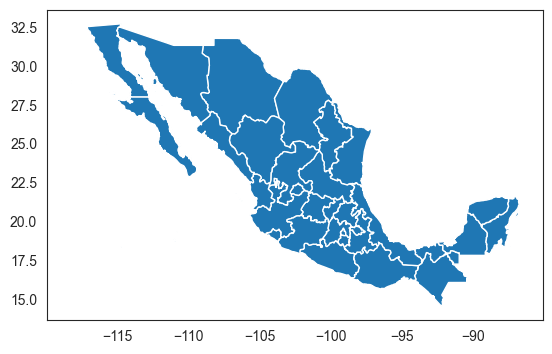

In [55]:
geo_df.plot()

## Correlación entre variables

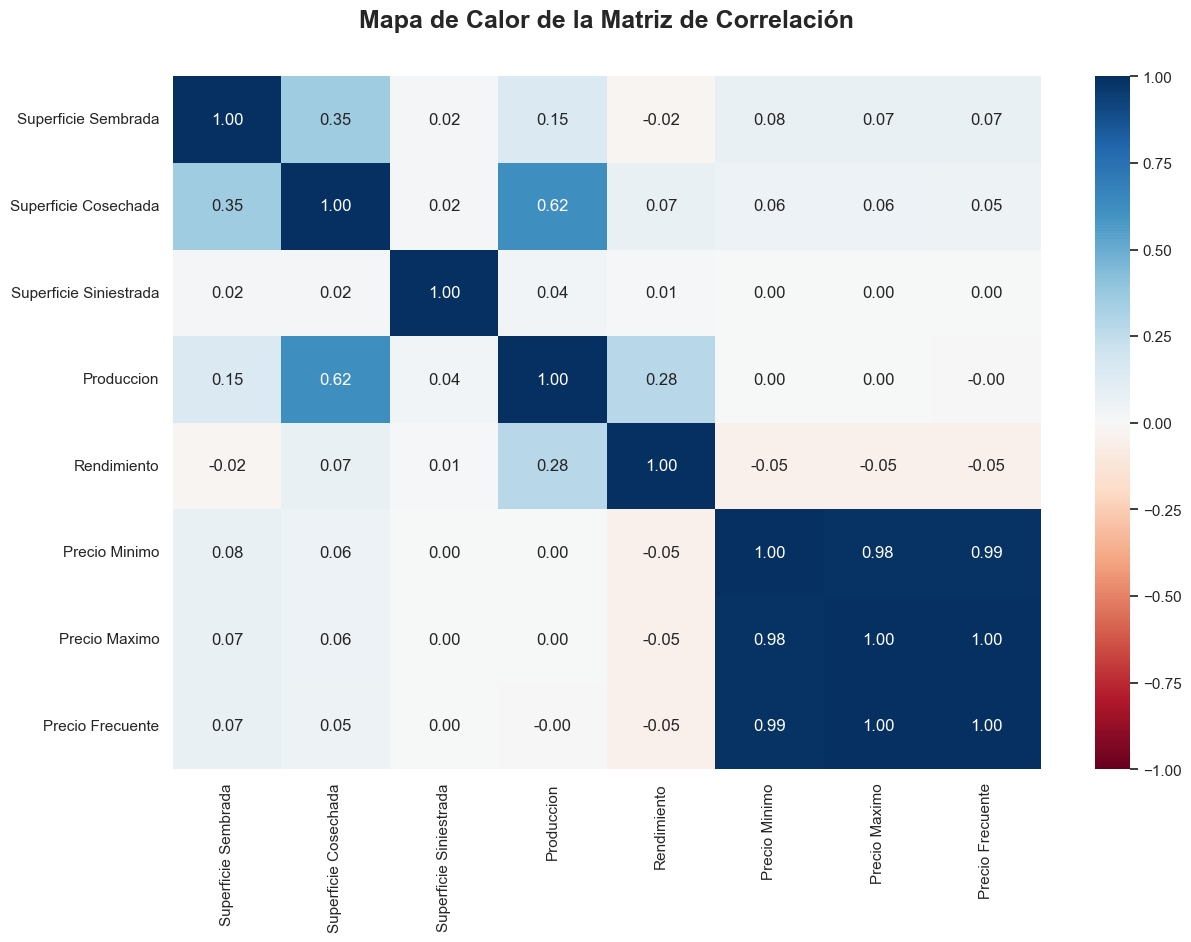

In [65]:
# Calcula la matriz de correlación
correlation_matrix = df_merge[VARIABLES_NUMERICAS].corr()

# Fijar estilo
sns.set(style="white")

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize = (14,9))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de Calor de la Matriz de Correlación', pad=40, ha='center', va='center', fontsize=18, fontweight='bold')
# Rotar los labels del eje x a 90 grados
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

#Mostrar gráfica
plt.show()
     